Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [3]:
!unzip drive/MyDrive/twitsentanalis.zip

Archive:  drive/MyDrive/twitsentanalis.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
import pandas as pd

df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
max_words = 2000
max_len = 15
num_classes = 1

# Training
epochs = 15
batch_size = 512
print_batch_n = 100

In [7]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Наблюдается выраженный дисбаланс классов. Для наилучшего качества уравняем количество положительных и отрицательных твиттов

In [8]:
df = df[(df.label == 0) & (df.id < 2400) | (df.label == 1)]

In [9]:
df.label.value_counts()

1    2242
0    2232
Name: label, dtype: int64

In [10]:
df_val = df[(df.label == 0) & (df.id > 2100) | (df.label == 1) & (df.id > 28000)]

In [11]:
df_val.label.value_counts()

0    284
1    279
Name: label, dtype: int64

In [12]:
df_train = df[(df.label == 0) & (df.id < 2100) | (df.label == 1) & (df.id < 28000)]

In [13]:
df_train.label.value_counts()

1    1963
0    1947
Name: label, dtype: int64

In [14]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=744e8e3a2ade3992adfef3e0b64c59f993aad8ae35b15dafc903372889602d1b
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=85bd7c43b7d81ce62bb5e290a6b2ba69a8369bc0332bd1b8fc0e39ae6b296a8a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built stop-words docopt


In [15]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np

In [16]:
sw = set(get_stop_words("en"))
# sw

In [17]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [18]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [19]:
df_train['tweet'].iloc[19:].values

array(['as we all know, essential oils are not made of chemicals. ',
       '#euro2016 people blaming ha for conceded goal was it fat rooney who gave away free kick knowing bale can hit them from there.  ',
       'sad little dude..   #badday #coneofshame #cats #pissed #funny #laughs ',
       ..., ' destroyed in one minute #janeelliot   ',
       '@user #feminismiscancer #feminismisterrorism #feminismmuktbharat why  #malevote is ignored  @user',
       'mother daughter blowjob  white girl has sex with black guy '],
      dtype=object)

In [20]:
df_train['tweet'].iloc[19:].apply(preprocess_text).values

array(['know essential oils notmade chemicals',
       'euro2016 people blaming ha conceded goal fat rooney gave away free kick knowing bale can hit',
       'sad little dude badday coneofshame cats pissed funny laughs', ...,
       'destroyed one minute janeelliot',
       'user feminismiscancer feminismisterrorism feminismmuktbharat malevote ignored user',
       'mother daughter blowjob white girl sex black guy'], dtype=object)

Лемматизация трейновой и тестовой выборок

In [21]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 3910/3910 [00:00<00:00, 4486.65it/s]
<ipython-input-21-590fcd0f3cce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
100%|██████████| 563/563 [00:00<00:00, 3249.95it/s]
<ipython-input-21-590fcd0f3cce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)


In [22]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

Произведём токенезацию

In [23]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['user', 'father', 'dysfunctional', 'selfish', 'drags']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [24]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [25]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [26]:
tokens_filtered_top[:10]

['user',
 'amp',
 'love',
 'trump',
 'like',
 'will',
 'just',
 'people',
 'day',
 'happy']

Создадим словарь из токенов

In [27]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'amp': 2,
 'love': 3,
 'trump': 4,
 'like': 5,
 'will': 6,
 'just': 7,
 'people': 8,
 'day': 9,
 'happy': 10,
 'new': 11,
 'libtard': 12,
 'white': 13,
 'black': 14,
 'im': 15,
 'u': 16,
 'dont': 17,
 'can': 18,
 'one': 19,
 'now': 20,
 'get': 21,
 'today': 22,
 'good': 23,
 'time': 24,
 'politics': 25,
 'racist': 26,
 'allahsoil': 27,
 'might': 28,
 'feel': 29,
 'us': 30,
 'thankful': 31,
 'liberal': 32,
 'go': 33,
 'cant': 34,
 'positive': 35,
 'see': 36,
 '2': 37,
 'sjw': 38,
 'women': 39,
 'hate': 40,
 'life': 41,
 'obama': 42,
 'take': 43,
 'listen': 44,
 'retweet': 45,
 'racism': 46,
 'bihday': 47,
 'think': 48,
 'want': 49,
 'never': 50,
 'back': 51,
 'got': 52,
 'america': 53,
 'via': 54,
 'great': 55,
 'work': 56,
 'girl': 57,
 'know': 58,
 'man': 59,
 'right': 60,
 'youre': 61,
 'make': 62,
 'really': 63,
 'say': 64,
 '2016': 65,
 'fathers': 66,
 'way': 67,
 'world': 68,
 'sad': 69,
 'weekend': 70,
 'need': 71,
 'video': 72,
 'stomping': 73,
 'thanks': 74,
 'goin

Перевод текста в последовательности

In [28]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [29]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 988 ms, sys: 1.24 ms, total: 990 ms
Wall time: 2.11 s


In [30]:
x_train.shape

(3910, 15)

In [31]:
df_train['tweet'].iloc[0]

'user father dysfunctional selfish drags kids dysfunction run'

In [32]:
x_train[0]

array([   1,  189, 1611,  272, 1014,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [36]:
from torch.utils.data import DataLoader, Dataset
import torch


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [37]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Обучение LSTM

In [40]:
from torch import nn


class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [41]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [42]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [43]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    lstm_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/15]. Step [8/8]. Loss: 0.691. Acc: 0.498. Test loss: 0.687. Test acc: 0.504
Epoch [2/15]. Step [8/8]. Loss: 0.696. Acc: 0.498. Test loss: 0.694. Test acc: 0.517
Epoch [3/15]. Step [8/8]. Loss: 0.683. Acc: 0.537. Test loss: 0.680. Test acc: 0.673
Epoch [4/15]. Step [8/8]. Loss: 0.671. Acc: 0.667. Test loss: 0.654. Test acc: 0.684
Epoch [5/15]. Step [8/8]. Loss: 0.660. Acc: 0.705. Test loss: 0.663. Test acc: 0.702
Epoch [6/15]. Step [8/8]. Loss: 0.635. Acc: 0.725. Test loss: 0.604. Test acc: 0.714
Epoch [7/15]. Step [8/8]. Loss: 0.623. Acc: 0.744. Test loss: 0.626. Test acc: 0.735
Epoch [8/15]. Step [8/8]. Loss: 0.540. Acc: 0.762. Test loss: 0.531. Test acc: 0.753
Epoch [9/15]. Step [8/8]. Loss: 0.498. Acc: 0.787. Test loss: 0.472. Test acc: 0.776
Epoch [10/15]. Step [8/8]. Loss: 0.481. Acc: 0.813. Test loss: 0.455. Test acc: 0.803
Epoch [11/15]. Step [8/8]. Loss: 0.406. Acc: 0.826. Test loss: 0.396. Test acc: 0.826
Epoch [12/15]. Step [8/8]. Loss: 0.412. Acc: 0.840. Test loss: 

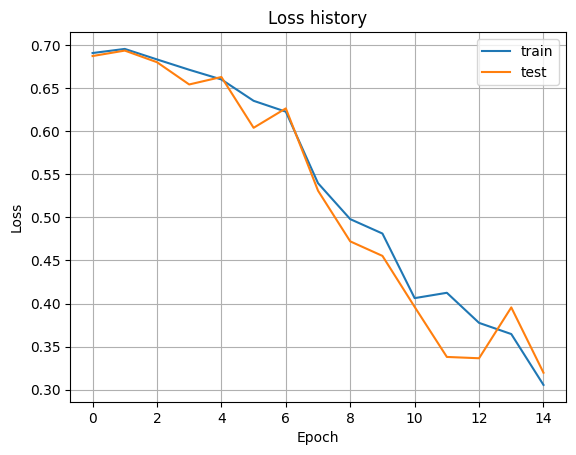

In [44]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Gated Recurrent Unit

In [45]:
from torch import nn


class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [46]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [47]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [48]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    gru_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/15]. Step [8/8]. Loss: 0.690. Acc: 0.527. Test loss: 0.687. Test acc: 0.618
Epoch [2/15]. Step [8/8]. Loss: 0.683. Acc: 0.638. Test loss: 0.676. Test acc: 0.661
Epoch [3/15]. Step [8/8]. Loss: 0.675. Acc: 0.661. Test loss: 0.655. Test acc: 0.679
Epoch [4/15]. Step [8/8]. Loss: 0.648. Acc: 0.701. Test loss: 0.628. Test acc: 0.694
Epoch [5/15]. Step [8/8]. Loss: 0.619. Acc: 0.719. Test loss: 0.622. Test acc: 0.712
Epoch [6/15]. Step [8/8]. Loss: 0.572. Acc: 0.742. Test loss: 0.591. Test acc: 0.735
Epoch [7/15]. Step [8/8]. Loss: 0.532. Acc: 0.753. Test loss: 0.525. Test acc: 0.746
Epoch [8/15]. Step [8/8]. Loss: 0.494. Acc: 0.779. Test loss: 0.464. Test acc: 0.762
Epoch [9/15]. Step [8/8]. Loss: 0.426. Acc: 0.798. Test loss: 0.484. Test acc: 0.785
Epoch [10/15]. Step [8/8]. Loss: 0.414. Acc: 0.820. Test loss: 0.463. Test acc: 0.812
Epoch [11/15]. Step [8/8]. Loss: 0.369. Acc: 0.838. Test loss: 0.420. Test acc: 0.837
Epoch [12/15]. Step [8/8]. Loss: 0.365. Acc: 0.849. Test loss: 

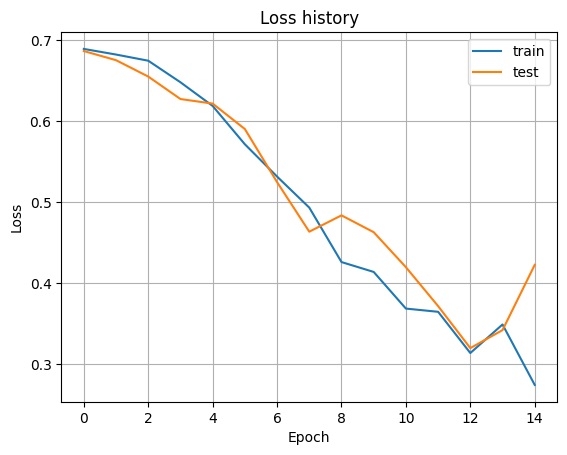

In [49]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

Выводы:
* архитектура LSTM и GRU для данной задачи позволяетс яполучить более стабильный результат на тестовых данных с более высоким показателями метрики.
* При сравнительном анализе LSTM показала более высокие значения метрики на тестовом наборе данных.